# RNN

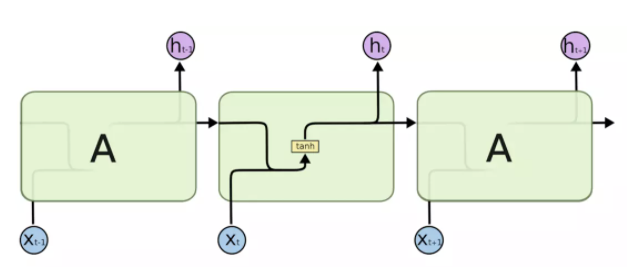

In [72]:
import numpy as np 
  
'''Param'''
X = [1,2,3] 
state = [0.0, 0.0] 
w_cell_state = np.asarray([[0.1, 0.2], [0.3, 0.4]]) 
w_cell_input = np.asarray([0.5, 0.6]) 
b_cell = np.asarray([0.1, -0.1]) 
w_output = np.asarray([[1.0], [2.0]]) 
b_output = 0.1
  
'''Forward Propagation'''

for i in range(len(X)): 
    
    before_activation = np.dot(state, w_cell_state) + X[i] * w_cell_input + b_cell 
    state = np.tanh(before_activation) 
    final_output = np.dot(state, w_output) + b_output 
    print ("before activation: ", before_activation) 
    print ("state: ", state) 
    print ("output: ", final_output)
    


before activation:  [0.6 0.5]
state:  [0.53704957 0.46211716]
output:  [1.56128388]
before activation:  [1.2923401  1.39225678]
state:  [0.85973818 0.88366641]
output:  [2.72707101]
before activation:  [1.95107374 2.2254142 ]
state:  [0.96040283 0.97693139]
output:  [3.01426561]


# LSTM

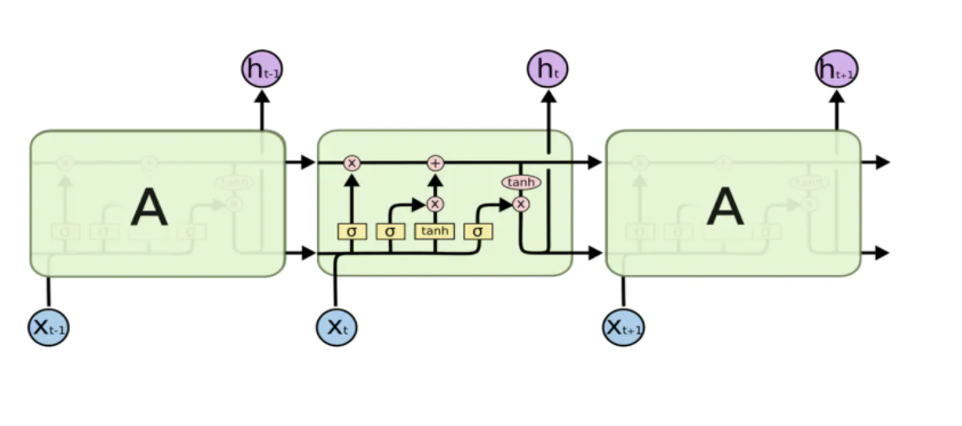

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
 
'''Basic param'''

rnn_unit=10      
input_size=7
output_size=1
lr=0.0006 


'''Import data'''
f=open('./data/dataset_2.csv')
df=pd.read_csv(f)     
data=df.iloc[:,2:10].values


 
'''Get training data'''

def get_train_data(batch_size=60,time_step=20,train_begin=0,train_end=5800):
    batch_index=[]
    data_train=data[train_begin:train_end]
    normalized_train_data=(data_train-np.mean(data_train,axis=0))/np.std(data_train,axis=0)  
    train_x,train_y=[],[]   
    for i in range(len(normalized_train_data)-time_step):
        if i % batch_size==0:
            batch_index.append(i)
        x=normalized_train_data[i:i+time_step,:7]
        y=normalized_train_data[i:i+time_step,7,np.newaxis]
        train_x.append(x.tolist())
        train_y.append(y.tolist())
    batch_index.append((len(normalized_train_data)-time_step))
    return batch_index,train_x,train_y

'''Get Testing data'''

def get_test_data(time_step=20,test_begin=5800):
    data_test=data[test_begin:]
    mean=np.mean(data_test,axis=0)
    std=np.std(data_test,axis=0)
    normalized_test_data=(data_test-mean)/std  
    size=(len(normalized_test_data)+time_step-1)//time_step  
    test_x,test_y=[],[] 
    for i in range(size-1):
        x=normalized_test_data[i*time_step:(i+1)*time_step,:7]
        y=normalized_test_data[i*time_step:(i+1)*time_step,7]
        test_x.append(x.tolist())
        test_y.extend(y)
    test_x.append((normalized_test_data[(i+1)*time_step:,:7]).tolist())
    test_y.extend((normalized_test_data[(i+1)*time_step:,7]).tolist())
    return mean,std,test_x,test_y

 



In [96]:
tf.reset_default_graph()

'''Neural Network'''
 
weights={
         'in':tf.Variable(tf.random_normal([input_size,rnn_unit])),
         'out':tf.Variable(tf.random_normal([rnn_unit,1]))
        }
biases={
        'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
        'out':tf.Variable(tf.constant(0.1,shape=[1,]))
       }
 

'''LSTM'''
def LSTM(X):
    '''Batch and step'''
    batch_size=tf.shape(X)[0];time_step=tf.shape(X)[1]
    
    '''Neural Weights'''
    w_in=weights['in'];b_in=biases['in'] 
    w_out=weights['out'];b_out=biases['out']
    
    '''Initialization'''
    input=tf.reshape(X,[-1,input_size])  
    input_rnn=tf.matmul(input,w_in)+b_in
    input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit])
    
    '''LSTM Cell''' 
    with tf.variable_scope('cell_def',reuse=tf.AUTO_REUSE):
        cell=tf.nn.rnn_cell.BasicLSTMCell(rnn_unit)
        init_state=cell.zero_state(batch_size,dtype=tf.float32)
        
    '''LSTM'''    
    with tf.variable_scope('rnn_def',reuse=tf.AUTO_REUSE):
        output_rnn,final_states=tf.nn.dynamic_rnn(cell, input_rnn,initial_state=init_state, dtype=tf.float32)  
        output=tf.reshape(output_rnn,[-1,rnn_unit])
        pred=tf.matmul(output,w_out)+b_out
    return pred,final_states
 
 
 
    
    
def Train_LSTM(batch_size=80,time_step=15,train_begin=2000,train_end=5800):
    X=tf.placeholder(tf.float32, shape=[None,time_step,input_size])
    Y=tf.placeholder(tf.float32, shape=[None,time_step,output_size])
    '''Sampling form 2001th to 5785th data'''
    batch_index,train_x,train_y=get_train_data(batch_size,time_step,train_begin,train_end)
    print(np.array(train_x).shape)# 3785  15  7
    
    '''3785 sentences, 15 words, 7 features'''
    
    pred,_=LSTM(X)
    
    '''MSE loss'''
    loss=tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))
    train_op=tf.train.AdamOptimizer(lr).minimize(loss)
    saver=tf.train.Saver(tf.global_variables(),max_to_keep=15) 
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(200):
            for step in range(len(batch_index)-1):
                _,loss_=sess.run([train_op,loss],feed_dict={X:train_x[batch_index[step]:batch_index[step+1]],Y:train_y[batch_index[step]:batch_index[step+1]]})
            print(str(i)+"th iteration's Loss: ",loss_)
            if i % 200==0:
                print("Save model",saver.save(sess,'model/stock2.model',global_step=i))

Train_LSTM()
 
 


(3785, 15, 7)
0th iteration's Loss:  0.09670213
Save model model/stock2.model-0
1th iteration's Loss:  0.03796174
2th iteration's Loss:  0.030697588
3th iteration's Loss:  0.02484197
4th iteration's Loss:  0.020262295
5th iteration's Loss:  0.017295966
6th iteration's Loss:  0.015445643
7th iteration's Loss:  0.01428951
8th iteration's Loss:  0.013564179
9th iteration's Loss:  0.013111539
10th iteration's Loss:  0.012787872
11th iteration's Loss:  0.01247258
12th iteration's Loss:  0.012097323
13th iteration's Loss:  0.011653873
14th iteration's Loss:  0.011163663
15th iteration's Loss:  0.01069315
16th iteration's Loss:  0.010317767
17th iteration's Loss:  0.0099075455
18th iteration's Loss:  0.009412754
19th iteration's Loss:  0.008900397
20th iteration's Loss:  0.008412049
21th iteration's Loss:  0.007946712
22th iteration's Loss:  0.007507636
23th iteration's Loss:  0.007093785
24th iteration's Loss:  0.00670715
25th iteration's Loss:  0.0063469484
26th iteration's Loss:  0.0060127

INFO:tensorflow:Restoring parameters from model/stock2.model-0
16 309


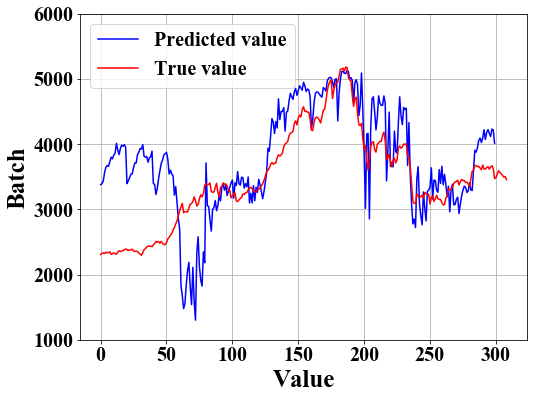

In [101]:


'''Prediction'''

def Prediction(time_step=20):
    X=tf.placeholder(tf.float32, shape=[None,time_step,input_size])
    mean,std,test_x,test_y=get_test_data(time_step)
    pred,_=LSTM(X)    
    saver=tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        '''Load the model'''
        module_file = tf.train.latest_checkpoint('model')
        saver.restore(sess, module_file)
        test_predict=[]
        
        print(len(test_x),len(test_y))
        for step in range(len(test_x)-1):
            prob=sess.run(pred,feed_dict={X:[test_x[step]]})  
            predict=prob.reshape((-1))
            test_predict.extend(predict)
            
        test_y=np.array(test_y)*std[7]+mean[7]
        test_predict=np.array(test_predict)*std[7]+mean[7]
        
        
        acc=np.average(np.abs(test_predict-test_y[:len(test_predict)])/test_y[:len(test_predict)])
        
        
        figsize = 8,6

        font_label = {'family' : 'Times New Roman','weight' : 'normal','size': 25}

        font_legend = {'family' : 'Times New Roman','weight' : 'normal','size': 20}

        figure, ax = plt.subplots(figsize=figsize)

        labels = ax.get_xticklabels() + ax.get_yticklabels()

        [label.set_fontsize(20) for label in labels]

        [label.set_fontname('Times New Roman') for label in labels]
        
        ax.plot(list(range(len(test_predict))), test_predict, color='b',label='Predicted value')
        
        ax.plot(list(range(len(test_y))), test_y,  color='r',label='True value')
        
        ax.set_ylabel('Batch',font_label)

        ax.set_xlabel('Value',font_label)
        
        ax.legend(loc = 'upper left',prop=font_legend)
        
        ax.set_ylim([1000,6000])
        
        plt.grid()
        
        plt.show()
        
Prediction()